# Projeto para classificar se a imagem é gerada pelo Stable Diffusion ou é real

Este notebook contém os códigos e resultados do projeto proposto

In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import Report
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import random
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\heigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparação do dataset
Essa seção carrega o dataset CIFAKE, no qual contém o dataset CIFAR-10 e 60 mil imagens geradas pelo Stable Diffusion

As imagens são lidas a partir do diretório "Dataset" e salvas e guardadas na memória nas variáveis: trainset e validset.

In [2]:
orig_dir   = "Dataset/train_all"
nclasses   = 2


width       = 32 
height      = 32
nchannels   = 3
maxval      = 255
input_shape = (nchannels,height,width)


train_perc = 0.90


data = glob(orig_dir+"/*.jpg")

num_train_samples = int(len(data)*train_perc)

np.random.shuffle(data)

trainset = data[:num_train_samples] 
validset = data[num_train_samples:]

É definido a classe que irá guardar o dataset.

In [3]:
prep = transforms.Compose([
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

class ImageDataset(): 
    def __init__(self, dataset, transform=None):

        classes = {"fake": 1, "real": 0}
        self.dataset   = dataset
        self.targets   = [classes[str(x).split("\\")[-1].split("_")[0]] for x in self.dataset]
        self.transform = transform

    def __len__(self): return len(self.dataset) 

    def __getitem__(self, ix):  
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) 
        if (self.transform is not None):
            image = self.transform(image)
        else:
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target)

In [5]:
trainsetV1 = ImageDataset(trainset, prep)
validsetV1 = ImageDataset(validset, prep)

Nos blocos seguintes é possivel verificar algumas informações do dataset.

Number of images: 90000
Images are 32x32x3
Class of the image: fake


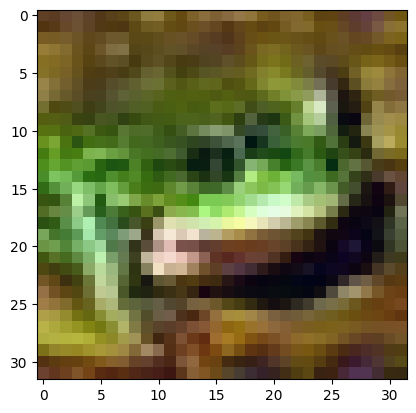

In [94]:
ind = random.randint(0, len(trainsetV1))
classes_dict = {0: "real", 1: "fake"}
print("Number of images:", len(trainsetV1))
image, target = trainsetV1[ind] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image:", classes_dict[target])
plt.show()

Os dataloaders já são instanciados nesse momento.

In [57]:
batchsize = 32
trainloadV1 = DataLoader(trainsetV1, batch_size=batchsize, shuffle=True)
validloadV1 = DataLoader(validsetV1, batch_size=batchsize, shuffle=True)

## Implementação e avaliação de uma CNN

Nessa seção é implementada e treinada uma rede neural convolucional.

No bloco seguinte é implementado a arquitetura da rede, com duas camadas convolucionais.

In [7]:

def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(        
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),stride=1, padding=1, bias=False),        
        nn.BatchNorm2d(num_features=nchannels_out),        
        nn.ReLU(),        
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class HandCraftNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(HandCraftNet, self).__init__()

        self.conv1 = conv_block(input_shape[0],32,2)
        self.conv2 = conv_block(32,256,2) 
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18432, out_features=64, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(64, num_classes)
        )
        
        self._initialize_weights()

    def forward(self, x):        
        x1 = self.conv1(x)
        x2 = self.conv2(x1)        
        x1 = torch.nn.functional.interpolate(x1, scale_factor=(0.5, 0.5), mode='nearest',recompute_scale_factor=True)        
        x  = torch.cat((x1, x2), dim=1)
        
        x = torch.flatten(x, start_dim=1)
        
        y = self.classifier(x)
  
        return y
  
    def _initialize_weights(self):        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):                
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels                                    
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:                    
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):                                
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:                
                    m.bias.data.zero_()

O modelo é instanciado.

In [99]:
modelHF = HandCraftNet(input_shape, nclasses).to(device)
print(modelHF)

HandCraftNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=18432, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)


É definido o critétio com a CrossEntropyLoss.

In [4]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long())             
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization

    pred_labels   = torch.max(preds, 1)[1]
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc

criterion = Criterion

In [101]:
optimizer    = optim.Adam(modelHF.parameters(), lr=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Métodos de treinamento e validação de cada batch.

In [5]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()


O treinamento é realizado.

In [96]:
n_epochs = 20
log = Report(n_epochs)

for ex in range(n_epochs):
    N = len(trainloadV1)

    for bx, data in enumerate(trainloadV1):
        loss, acc = train_batch(modelHF, data, optimizer, criterion, device)
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validloadV1)
    for bx, data in enumerate(validloadV1):
        loss, acc = validate_batch(modelHF, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%2==0: log.report_avgs(ex+1)
    lr_scheduler.step()

EPOCH: 2.000  trn_acc: 0.875  trn_loss: 0.306  val_loss: 0.262  val_acc: 0.901  (115.08s - 1035.68s remaining)
EPOCH: 4.000  trn_acc: 0.909  trn_loss: 0.235  val_loss: 0.219  val_acc: 0.916  (229.95s - 919.81s remaining)
EPOCH: 6.000  trn_acc: 0.920  trn_loss: 0.206  val_loss: 0.192  val_acc: 0.930  (347.78s - 811.49s remaining)
EPOCH: 8.000  trn_acc: 0.929  trn_loss: 0.189  val_loss: 0.185  val_acc: 0.930  (465.51s - 698.27s remaining)
EPOCH: 10.000  trn_acc: 0.934  trn_loss: 0.176  val_loss: 0.175  val_acc: 0.934  (582.17s - 582.17s remaining)
EPOCH: 12.000  trn_acc: 0.938  trn_loss: 0.164  val_loss: 0.171  val_acc: 0.936  (698.07s - 465.38s remaining)
EPOCH: 14.000  trn_acc: 0.940  trn_loss: 0.163  val_loss: 0.172  val_acc: 0.936  (813.02s - 348.44s remaining)
EPOCH: 16.000  trn_acc: 0.940  trn_loss: 0.162  val_loss: 0.169  val_acc: 0.937  (927.42s - 231.86s remaining)
EPOCH: 18.000  trn_acc: 0.941  trn_loss: 0.161  val_loss: 0.168  val_acc: 0.938  (1042.03s - 115.78s remaining)
EPO

Gráficos do resultado.

100%|██████████| 121/121 [00:01<00:00, 83.14it/s] 


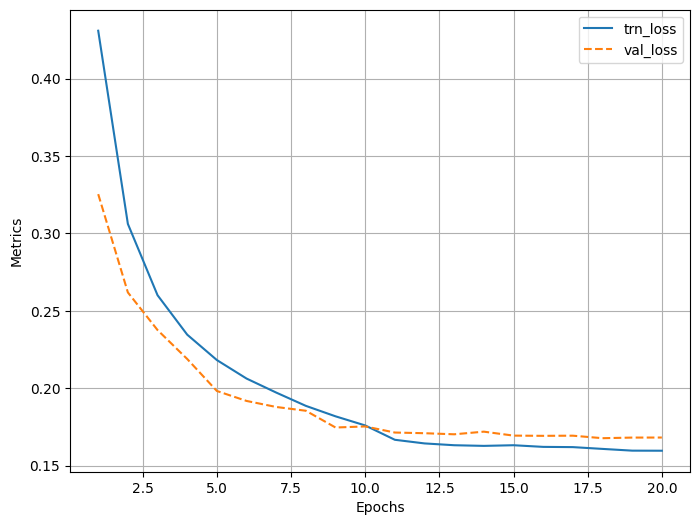

100%|██████████| 121/121 [00:01<00:00, 88.24it/s] 


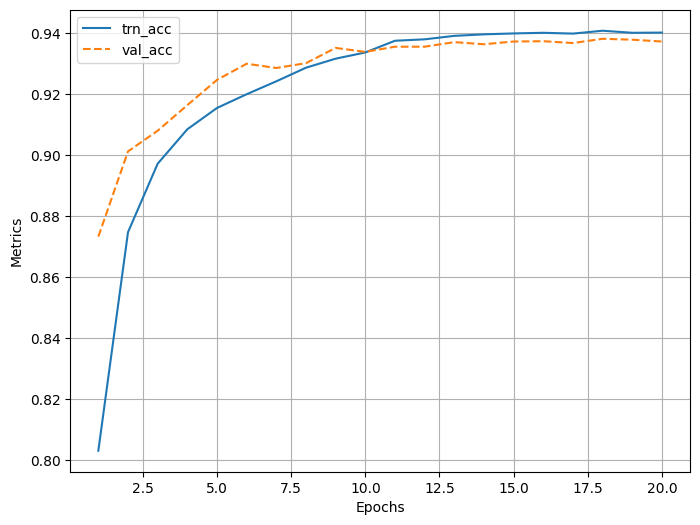

In [97]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

Dataset para teste

In [234]:
orig_dir   = "Dataset/test_all"


testset = glob(orig_dir+"/*.jpg")

print(len(testset))

testsetV1 = ImageDataset(testset, prep)

batchsize = 32
testload = DataLoader(testsetV1, batch_size=batchsize)

20000


Definido método de Teste que será usado nesse projeto.

In [113]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc = 0
    all_targets = []
    all_preds = []

    model.eval()

    with torch.no_grad():
        for bx, data in enumerate(testload):
            ims, targets = data
            ims = ims.to(device=device)
            targets = targets.to(device=device)
            preds = model(ims)
            loss, _ = criterion(model, preds, targets)

            loss = loss.item()

            mean_loss += loss

            preds = torch.argmax(preds, dim=1).cpu().numpy()
            targets = targets.cpu().numpy()

            all_targets.extend(targets)
            all_preds.extend(preds)

    mean_loss = mean_loss / N
    mean_acc = accuracy_score(all_targets, all_preds)

    class_accuracy = []
    unique_classes = np.unique(all_targets)
    for cls in unique_classes:
        cls_mask = np.array(all_targets) == cls
        cls_targets = np.array(all_targets)[cls_mask]
        cls_preds = np.array(all_preds)[cls_mask]
        cls_acc = accuracy_score(cls_targets, cls_preds)
        class_accuracy.append(cls_acc)

    cohen_kappa = cohen_kappa_score(all_targets, all_preds)

    return mean_loss, mean_acc, class_accuracy, cohen_kappa


Resultado do modelo treinado e também sendo salvo como arquivo.

In [120]:
(loss, acc, class_acc, kappa) = Test(modelHF, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f} Kappa: {:.6f}'.format(loss,acc,kappa))
for clss,element in enumerate(class_acc):
    print(f"{clss}: {element:.6f}", end=" ")

Loss: 0.168514 Acc: 0.935350 Kappa: 0.870700
0: 0.933500 1: 0.937200 

In [115]:
model_name  = 'modelHF.pth'
torch.save(modelHF.to('cpu').state_dict(), model_name)

## Utilizando GradCAM para verificar seções mais descriminativas das imagens

### Visualizando modelos previamente treinados

In [235]:
model = HandCraftNet(input_shape, nclasses)
  
state_dict  = torch.load('Model\modelHF.pth') 
  
model.load_state_dict(state_dict) 
model.to(device) 

HandCraftNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=18432, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

Funções para verificar as ativações do extrator de características.

In [236]:
def get_activations(model, x, device): 
    x = x.to(device) 
    x1 = model.conv1(x)
    x2 = model.conv2(x1)
    x1 = torch.nn.functional.interpolate(x1, scale_factor=(0.5, 0.5), mode='nearest', recompute_scale_factor=True) 
    x  = torch.cat((x1, x2), dim=1) 

    return x

def get_output_of_the_model(model, x, device):
    model.eval() 
    x = x.to(device) 
    output = model(x)
    return(output)

def get_heatmap(model, x, device, labels_map):
    
    xin = x.unsqueeze(0)
    activ  = get_activations(model, xin, device)
    logits = get_output_of_the_model(model, xin, device)
    pred   = logits.max(-1)[-1] 
    print("predicted label: ", labels_map[pred.cpu().detach().numpy()[0]])
    
    model.zero_grad() 
    logits[0,pred].backward(retain_graph=True) 
    
    print(activ.shape)
    
    for layer_name, layer in model.conv1.named_children():
        if layer_name == '0':
            grad1 = layer.weight.grad
            nchannels1 = grad1.shape[0]
            
            
            for i in range(16):
                activ[:,i,:,:] *= grad1[i].mean()
    for layer_name, layer in model.conv2.named_children():
        if layer_name == '0':
            grad2 = layer.weight.grad
            nchannels2 = grad2.shape[0]     
            for i in range(64):
                activ[:,i+16,:,:] *= grad2[i].mean()
                
    heatmap = torch.mean(activ, dim=1)[0].cpu().detach()

    heatmap = heatmap.squeeze(0).numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, (x.shape[2], x.shape[1]))
    return(heatmap)

def display_image_with_heatmap(img, heatmap, scale):
    heatmap = np.uint8(255.0*heatmap)
    width   = int(heatmap.shape[1]*scale)
    height  = int(heatmap.shape[0]*scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img     = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255-heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap*0.7 + img*0.3)
    
    return heatmap

Seleciona imagens do teste e demonstra o mapa de ativação

true label:  real
predicted label:  real
torch.Size([1, 288, 8, 8])


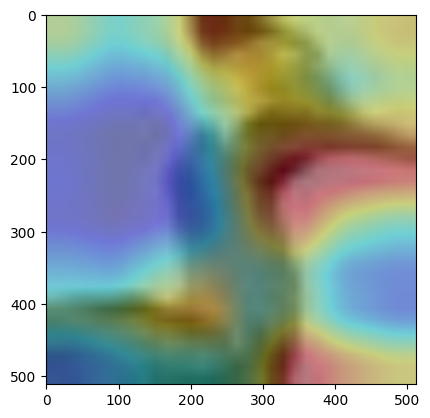

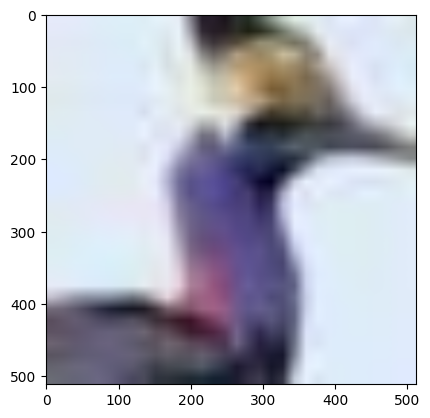

In [341]:
labels_map =  {0: "real", 1: "fake"}
index = random.randint(0, len(testsetV1))
x, true_label = testsetV1[index]

print("true label: ", labels_map[true_label])
heatmap = get_heatmap(model, x, device, labels_map)
x       = x.permute(1,2,0).numpy()
if (x.shape[2]==1): 
    x = x.squeeze(2)
    x = np.stack((x,)*3,axis=-1)  

scale = 16
heatmap = display_image_with_heatmap(x, heatmap, scale)

image, target = testsetV1[index] 
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')

width   = int(image.shape[1]*scale)
height  = int(image.shape[0]*scale)
image = cv2.resize(image, (width, height))


heatmap = np.uint8(heatmap*0.5 + image*0.5)


plt.imshow(heatmap)
plt.show()

plt.imshow(image)
plt.show()

Próximo bloco usada para salvar na memória imagens e o mapa de ativação.

In [238]:
ind = 0

In [342]:
heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

combined_image = np.hstack((image_rgb, heatmap_rgb))

cv2.imwrite(f"GradCAM/{labels_map[true_label]}_combined_{ind}.jpg", combined_image)
ind+=1

In [343]:
def get_heatmap(model, x, device, labels_map):
    
    xin = x.unsqueeze(0)
    activ  = get_activations(model, xin, device)
    logits = get_output_of_the_model(model, xin, device)
    pred   = logits.max(-1)[-1] 
    
    model.zero_grad() 
    logits[0,pred].backward(retain_graph=True) 
    
    
    for layer_name, layer in model.conv1.named_children():
        if layer_name == '0':
            grad1 = layer.weight.grad
            nchannels1 = grad1.shape[0]
            
            
            for i in range(16):
                activ[:,i,:,:] *= grad1[i].mean()
    for layer_name, layer in model.conv2.named_children():
        if layer_name == '0':
            grad2 = layer.weight.grad
            nchannels2 = grad2.shape[0]     
            for i in range(64):
                activ[:,i+16,:,:] *= grad2[i].mean()
                
    heatmap = torch.mean(activ, dim=1)[0].cpu().detach()

    heatmap = heatmap.squeeze(0).numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, (x.shape[2], x.shape[1]))
    return(heatmap, labels_map[pred.cpu().detach().numpy()[0]])

In [344]:
orig_dir   = "Generated\in_test"


genset = glob(orig_dir+"/*.jpg")
gensetV1 = ImageDataset(genset, prep)
gensetV2 = ImageDataset(genset)


In [345]:
wrong = 0
for index in range(len(genset)):
    labels_map =  {0: "real", 1: "fake"}
    x, true_label = gensetV1[index]

    heatmap, pred = get_heatmap(model, x, device, labels_map)
    if (pred == "real"):
        wrong += 1


    x       = x.permute(1,2,0).numpy()
    if (x.shape[2]==1): 
        x = x.squeeze(2)
        x = np.stack((x,)*3,axis=-1)  

    scale = 16
    heatmap = display_image_with_heatmap(x, heatmap, scale)

    image, target = gensetV2[index] 
    image     = image.permute(1,2,0).numpy()
    image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
    image     = image.astype('uint8')

    heatmap = np.uint8(heatmap*0.5 + image*0.5)

    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    combined_image = np.hstack((image_rgb, heatmap_rgb))

    cv2.imwrite(f"Generated\GradCAM\in_test\{labels_map[true_label]}_{pred}_{index+1}.jpg", combined_image)

acc = 100 - (wrong/0.3)
print(f"Acc: {acc:.2f}%")

Acc: 83.33%


In [350]:
orig_dir   = "Generated\out_test"


genset = glob(orig_dir+"/*.jpg")
gensetV1 = ImageDataset(genset, prep)
gensetV2 = ImageDataset(genset)


In [351]:
wrong = 0
for index in range(len(genset)):
    labels_map =  {0: "real", 1: "fake"}
    x, true_label = gensetV1[index]

    heatmap, pred = get_heatmap(model, x, device, labels_map)
    if (pred == "real"):
        wrong += 1


    x       = x.permute(1,2,0).numpy()
    if (x.shape[2]==1): 
        x = x.squeeze(2)
        x = np.stack((x,)*3,axis=-1)  

    scale = 16
    heatmap = display_image_with_heatmap(x, heatmap, scale)

    image, target = gensetV2[index] 
    image     = image.permute(1,2,0).numpy()
    image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
    image     = image.astype('uint8')

    heatmap = np.uint8(heatmap*0.5 + image*0.5)

    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    combined_image = np.hstack((image_rgb, heatmap_rgb))

    cv2.imwrite(f"Generated\GradCAM\out_test\{labels_map[true_label]}_{pred}_{index+1}.jpg", combined_image)

acc = 100 - (wrong/24 * 100)
print(f"Acc: {acc:.2f}%")

Acc: 62.50%
